In [122]:
import matplotlib.pyplot as plt
import os

import torch
import torch.nn.functional as F
from torchinfo import summary

import cv2
import numpy as np

from diffusers import DDPMScheduler, UNet2DModel
from datasets import RAMDatasetDIDC, LazyDatasetDIDC
from mt_DIDC_config import GROUPING_RULES, NEW_LABELS

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
DATA_PATH = 'New_dictionary'

In [3]:
noise_scheduler = DDPMScheduler(num_train_timesteps=10000, beta_schedule="sigmoid")
model = UNet2DModel(
    sample_size=64,  # Risoluzione input (es. 64x64 per test, 256x256 per serio)
    in_channels=1,   # 1 per MRI grayscale
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(128, 256, 512, 512),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [4]:
output = model(torch.randn(1, 1, 64, 64), torch.tensor([0]))  # Test forward pass

In [5]:
output.sample

tensor([[[[-6.0185e-02, -3.5693e-01, -1.5968e-01,  ...,  1.2421e-01,
            7.0289e-02, -6.0682e-02],
          [-3.6468e-01, -5.5553e-02,  4.1435e-02,  ..., -2.0116e-01,
           -2.0258e-01, -3.1689e-01],
          [-3.4169e-01,  5.6523e-04,  9.2196e-02,  ...,  2.8941e-01,
            1.1628e-04,  4.1686e-02],
          ...,
          [-9.0029e-02, -2.2355e-01,  1.9967e-01,  ..., -4.8573e-02,
            6.9292e-02, -1.0261e-02],
          [ 8.8815e-02,  1.8230e-01,  2.1277e-01,  ...,  2.6241e-01,
            1.9168e-01,  8.3357e-02],
          [ 3.2253e-01,  1.2678e-01, -7.0818e-02,  ...,  2.8973e-02,
            1.0215e-01,  1.2860e-01]]]], grad_fn=<ConvolutionBackward0>)

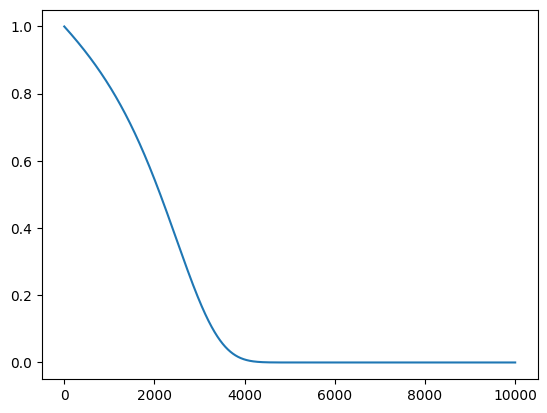

In [6]:

plt.plot(noise_scheduler.alphas_cumprod.cpu().numpy())

In [126]:
dataset = LazyDatasetDIDC(DATA_PATH, GROUPING_RULES, NEW_LABELS, target_size=(384,384), rm_black_slices=True, file_list=os.listdir(DATA_PATH)[:3], remap_nn=True, threshold_classes=100, min_blob_size=10)


Lazy Dataset: File...
35 samples indexed.


In [129]:
mask = dataset[11]['multiClassMask']
fg = dataset[11]['input_label']

mask.shape, fg.shape, mask.dtype, fg.dtype

(torch.Size([384, 384]), torch.Size([4, 384, 384]), torch.int64, torch.float32)

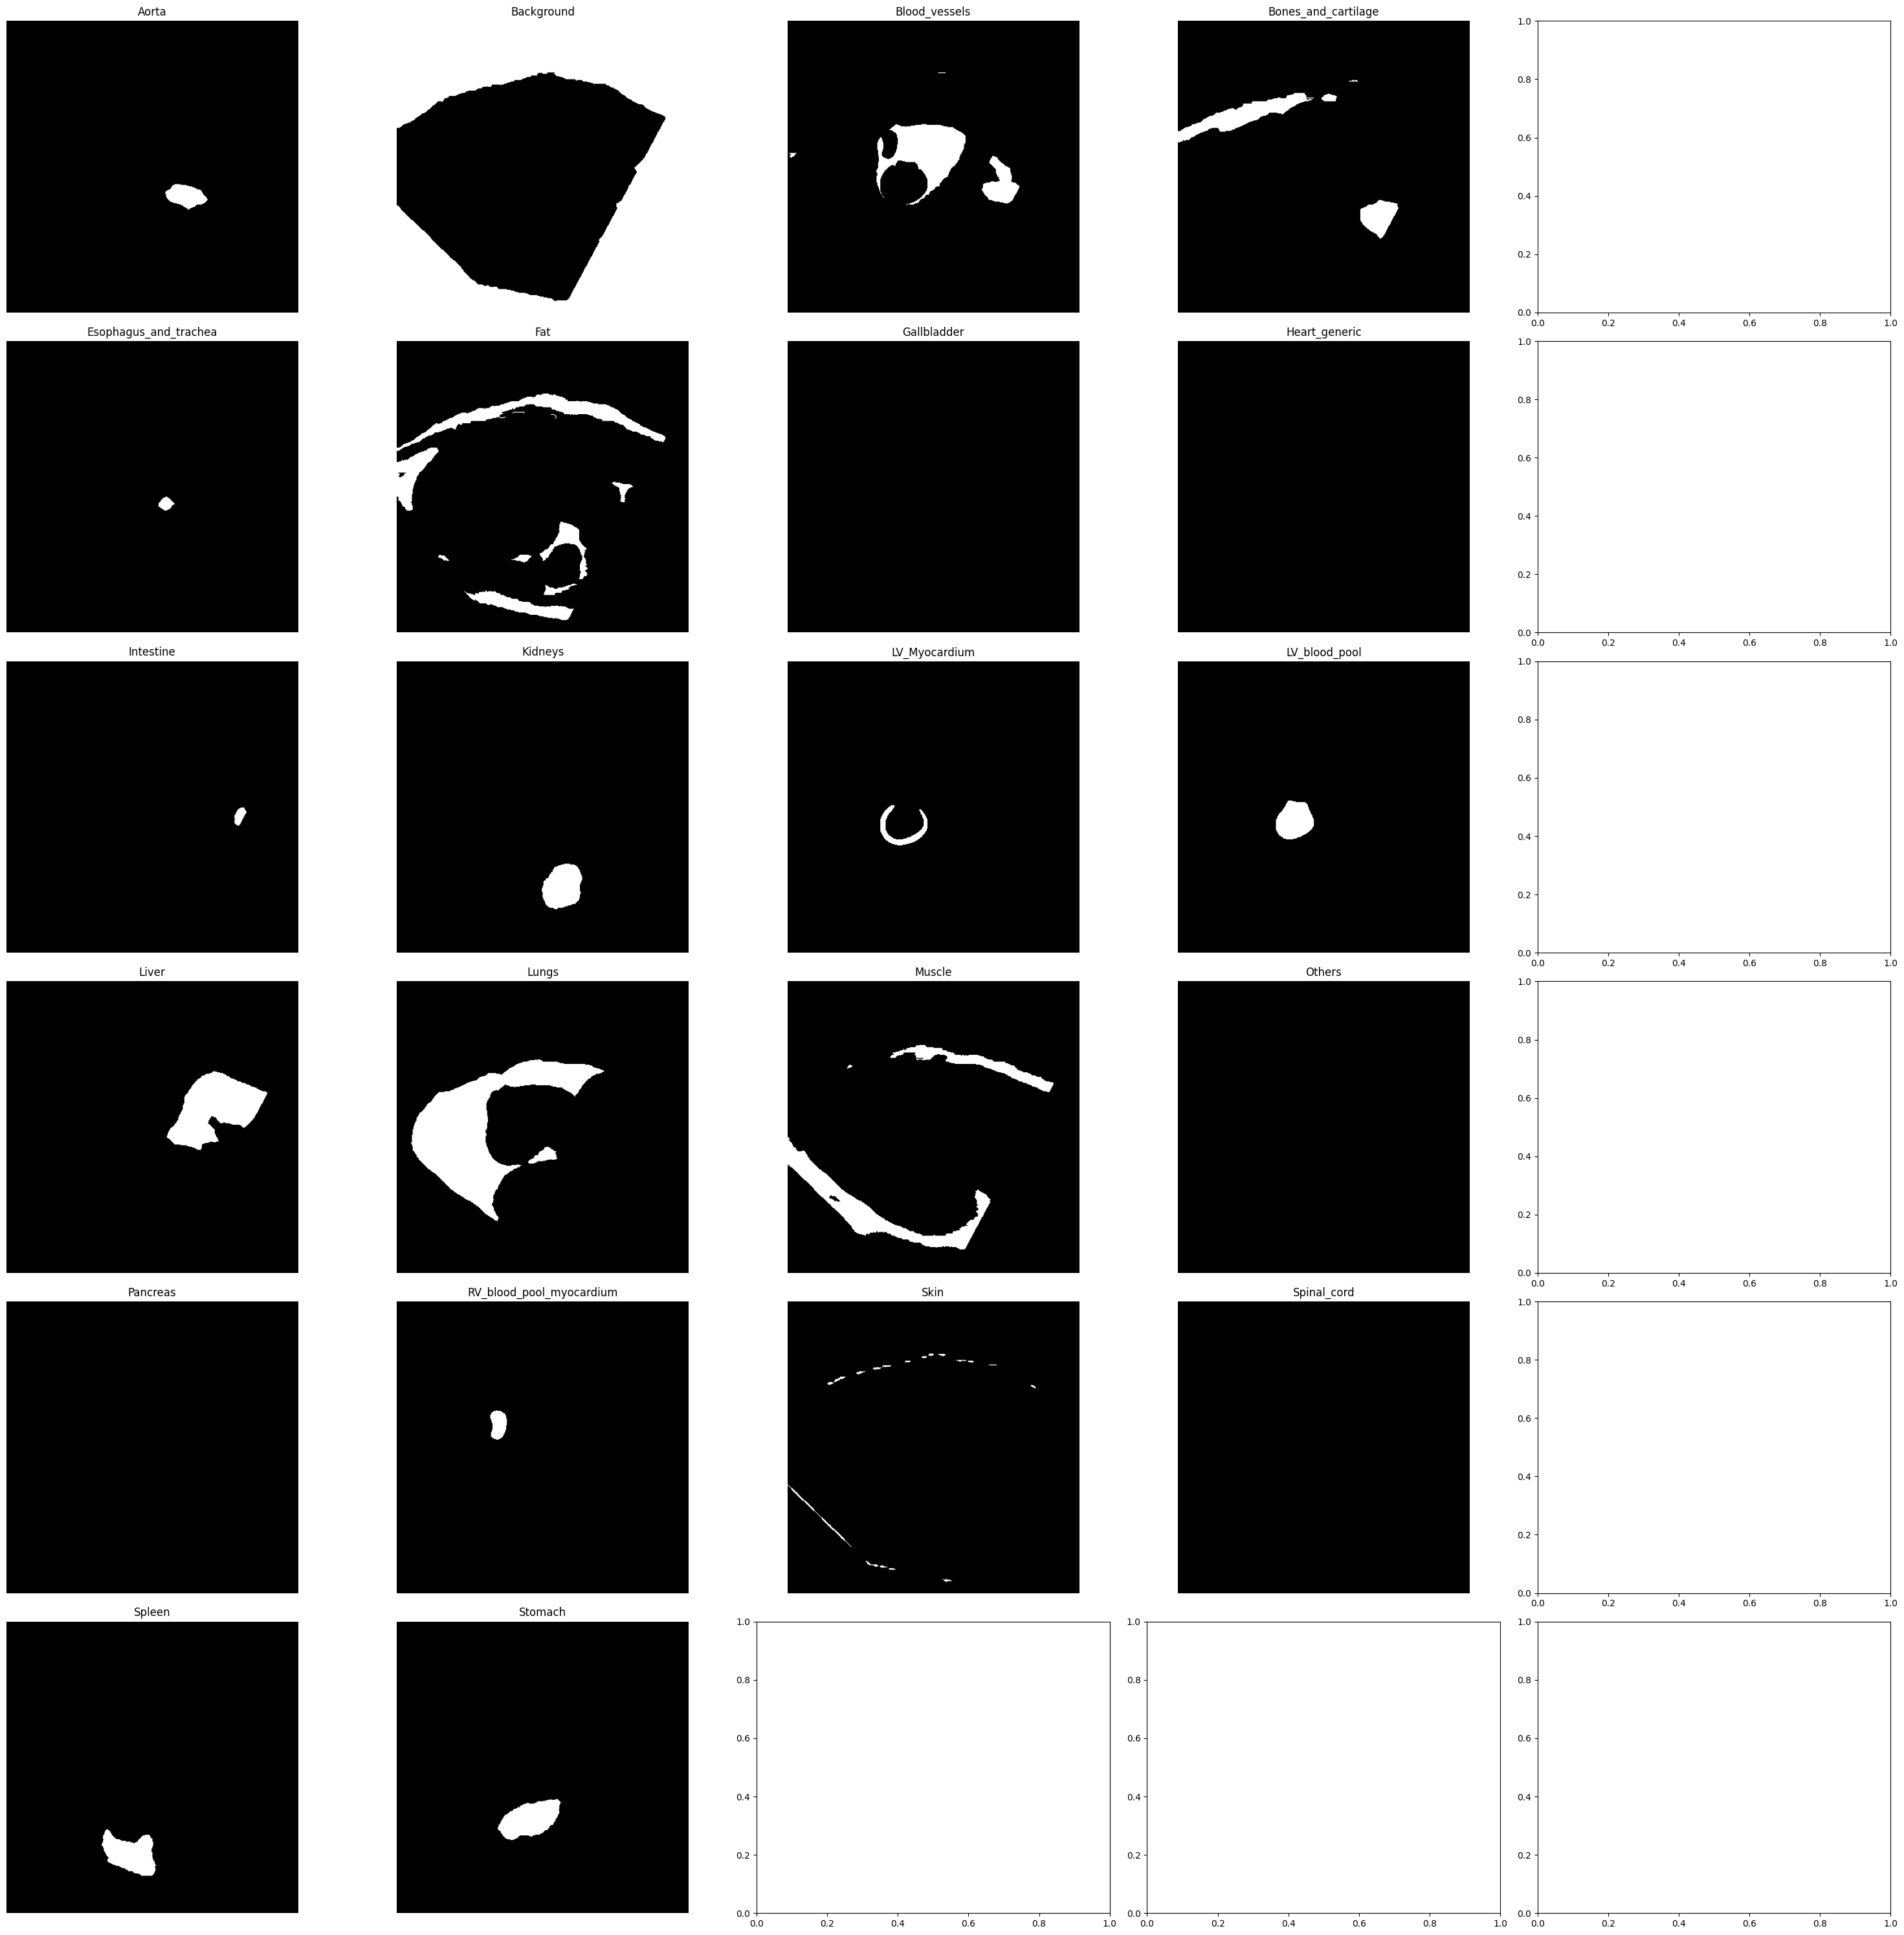

In [130]:
organs_to_show = len(dataset.new_labels)
fig, ax = plt.subplots(6, organs_to_show//5+1, figsize=(30, 30))
for i in range(organs_to_show):
    ax[i//4, i%4].imshow(mask == i, cmap='gray')
    ax[i//4, i%4].set_title(f"{dataset.new_labels[i]}")
    ax[i//4, i%4].axis('off')
plt.tight_layout()
plt.show()
    